In [23]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 12)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:20,.2f}'.format)
plt.style.use('seaborn-v0_8')

# Data Fetching and Cleaning

In [24]:
df = pd.read_csv('marketing_campaign_preprocessed.csv')
df['Education'] = df['Education'].astype('category').cat.codes
df['Marital_Status'] = df['Marital_Status'].astype('category').cat.codes
df.drop('Dt_Customer', axis=1, inplace=True)
df['Response'] = df['Response'].map({'Yes': 1, 'No': 0})
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Spending,Children
0,5524,1957,2,4,"58,138.00",0,0,58,635,88,...,0,0,0,0,3,11,1,66,1617,0
1,2174,1954,2,4,"46,344.00",1,1,38,11,1,...,0,0,0,0,3,11,0,69,27,2
2,4141,1965,2,5,"71,613.00",0,0,26,426,49,...,0,0,0,0,3,11,0,58,776,0
3,6182,1984,2,5,"26,646.00",1,0,26,11,4,...,0,0,0,0,3,11,0,39,53,1
4,5324,1981,4,3,"58,293.00",1,0,94,173,43,...,0,0,0,0,3,11,0,42,422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,10870,1967,2,3,"61,223.00",0,1,46,709,43,...,0,0,0,0,3,11,0,56,1341,1
2198,4001,1946,4,5,"64,014.00",2,1,56,406,0,...,0,1,0,0,3,11,0,77,444,3
2199,7270,1981,2,2,"56,981.00",0,0,91,908,48,...,0,0,0,0,3,11,0,42,1241,0
2200,8235,1956,3,5,"69,245.00",0,1,8,428,30,...,0,0,0,0,3,11,0,67,843,1


# Classification

* Predict Response or not

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=10000, solver='lbfgs', random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

# K fold cross validation and logistic regression
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Scores: ", scores)

Accuracy: 0.86 (+/- 0.02)
Scores:  [0.84580499 0.8707483  0.85454545 0.86818182 0.86590909]


# Score

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       369
           1       0.52      0.22      0.31        72

    accuracy                           0.84       441
   macro avg       0.69      0.59      0.61       441
weighted avg       0.81      0.84      0.81       441



<AxesSubplot: >

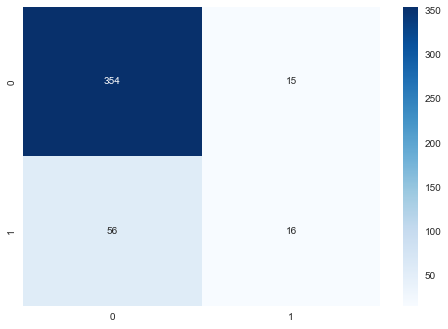

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

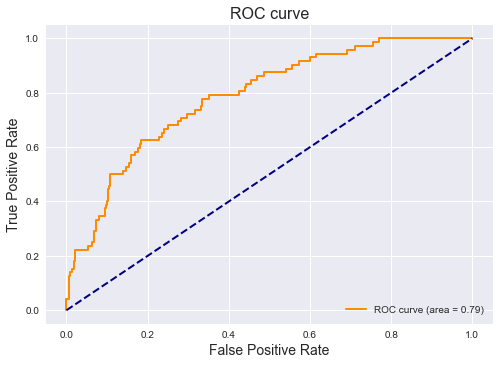

In [27]:
# ROC curve
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
            label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


# Best Subset Selection

In [29]:
X_train.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Age', 'Spending',
       'Children'],
      dtype='object')

In [77]:
from itertools import chain, combinations
import statsmodels.api as sm
from tqdm import tqdm

b_features = 1
n_features = 8
sub = []
cls = []
kft = []

col = ['Education', 'Marital_Status', 'Income', 'Kidhome', 'Recency', 'MntFruits', 'MntMeatProducts', 'NumWebVisitsMonth']
for k_features in tqdm(range(b_features, n_features + 1)):
    for subset in tqdm(combinations(col, k_features)):
        sub.append(subset)
        X_train_sub = X_train[list(subset)]
        X_test_sub = X_test[list(subset)]
        model.fit(X_train_sub, y_train)
        cls.append(model.score(X_test_sub, y_test))
        kft.append(k_features)
        
result = pd.DataFrame({'Subset': sub, 'classification': cls, 'K_features': kft})
result.sort_values('classification', ascending=False)

8it [00:00, 18.57it/s]00:00<?, ?it/s]
28it [00:01, 15.05it/s]0:00<00:03,  2.31it/s]
56it [00:04, 12.53it/s]0:02<00:07,  1.27s/it]
70it [00:06, 10.96it/s]0:06<00:13,  2.73s/it]
56it [00:05,  9.63it/s]0:13<00:16,  4.18s/it]
28it [00:03,  8.33it/s]0:18<00:14,  4.77s/it]
8it [00:03,  2.38it/s]00:22<00:08,  4.29s/it]
1it [00:00,  2.65it/s]00:25<00:03,  3.99s/it]
100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


,Subset,classification,K_features
235,"(Education, Income, Kidhome, Recency, MntMeatP...",0.85,6
252,"(Education, Income, Kidhome, Recency, MntFruit...",0.85,7
243,"(Marital_Status, Income, Recency, MntFruits, M...",0.84,6
253,"(Marital_Status, Income, Kidhome, Recency, Mnt...",0.84,7
212,"(Income, Kidhome, Recency, MntFruits, MntMeatP...",0.84,5
...,...,...,...
206,"(Marital_Status, Income, MntFruits, MntMeatPro...",0.83,5
152,"(Income, Kidhome, MntMeatProducts, NumWebVisit...",0.83,4
136,"(Marital_Status, Income, MntMeatProducts, NumW...",0.83,4
116,"(Education, Income, MntMeatProducts, NumWebVis...",0.83,4


In [78]:
result.to_csv('result.csv', index=False)

# Regularization

In [6]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=10000, solver='lbfgs', random_state=42) # ridge(l2-norm)
model.fit(X_train, y_train)
model.score(X_test, y_test)

# K fold cross validation and logistic regression
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Scores: ", scores)

Accuracy: 0.86 (+/- 0.02)
Scores:  [0.84580499 0.861678   0.85227273 0.86818182 0.86363636]


              precision    recall  f1-score   support

           0       0.88      0.98      0.93       385
           1       0.50      0.11      0.18        56

    accuracy                           0.87       441
   macro avg       0.69      0.55      0.55       441
weighted avg       0.83      0.87      0.84       441



<AxesSubplot: >

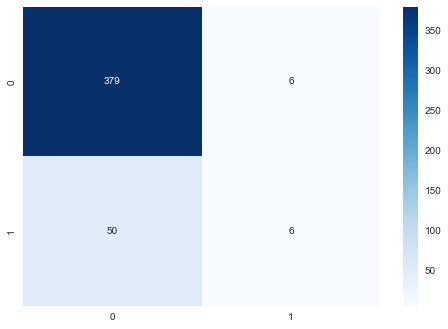

In [7]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

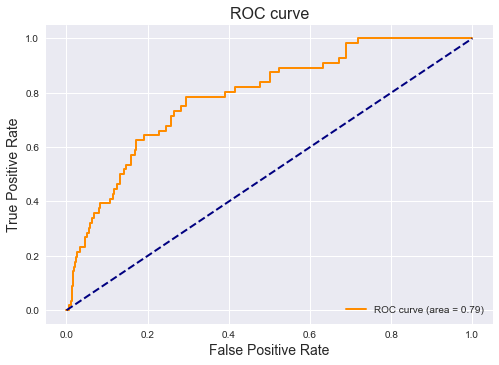

In [8]:
# ROC curve
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
            label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


# Boosting

In [9]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(estimator=LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=10000, solver='lbfgs', random_state=42), n_estimators=100, random_state=42)
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.8820861678004536

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       385
           1       0.50      0.11      0.18        56

    accuracy                           0.87       441
   macro avg       0.69      0.55      0.55       441
weighted avg       0.83      0.87      0.84       441



# PCA

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=10000, solver='lbfgs', random_state=42)
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.8367346938775511

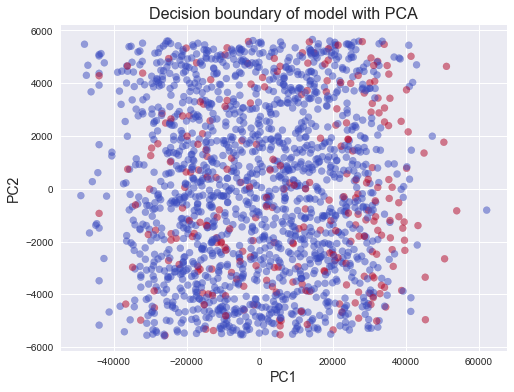

In [79]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.title('Decision boundary of model with PCA', fontsize=16)
plt.show()